# 분석에 필요한 라이브러리 설치

In [ ]:
# # 필요한 라이브러리 설치
# !pip install plotnine kmodes tqdm ipypb

In [1]:
import sqlite3
import pandas as pd
import numpy as np

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from plotnine import *
import plotnine

In [4]:
from sklearn.preprocessing import MinMaxScaler
from kmodes.kprototypes import KPrototypes

In [5]:
from tqdm import tqdm_notebook
import time
from ipypb import ipb

In [6]:
# 경고 메세지 안보이게 설정
import warnings
warnings.filterwarnings('ignore')

# 분석할 테이블 불러오기

In [7]:
# 영수증 번호가 E인 것들 select + 1번 + 5번 연결
con = sqlite3.connect("lpoint.db", isolation_level=None) # lpoint db 생성 or 연결

df2 = pd.read_sql('''
SELECT P.cust, D.ma_fem_dv, D.ages, D.zon_hlv, P.rct_no, P.de_dt, P.chnl_dv, P.cop_c, P.pd_c, C.clac_hlv_nm, C.clac_mcls_nm, C.pd_nm, P.de_hr, P.buy_am, P.buy_ct
FROM PDDE AS P, DEMO AS D, PD_CLAC AS C
WHERE P.cust = D.cust AND P.pd_c = C.pd_c AND P.rct_no LIKE 'E%'
GROUP BY P.cust, D.ma_fem_dv, D.ages, D.zon_hlv, P.rct_no, P.de_dt, P.chnl_dv, P.cop_c, P.pd_c, C.clac_hlv_nm, C.clac_mcls_nm, C.pd_nm, P.de_hr, P.buy_am, P.buy_ct;
''', con, index_col=None)

con.close()

# 불러온 테이블 컬럼명 한글로 재설정

In [8]:
df2.columns = ['고객번호', '성별', '연령대', '거주지분류대코드', '영수증번호', '구매일자', '채널구분', '제휴사', 
              '상품코드', '상품대분류명', '상품중분류명', '상품소분류명',
              '구매시간', '구매금액', '구매수량']

# 군집화에 사용할 필요한 컬럼명만 가져오기

In [9]:
ndf2 = df2[['성별', '연령대', '거주지분류대코드', '제휴사', '상품대분류명', '구매시간', '구매금액', '구매수량']]

# 구매월 변수 추가

In [10]:
# 구매월 추가
ndf2['구매월'] = df2['구매일자'].map(lambda x: str(x)[4:6]+'월')

In [11]:
ndf2.head()

,성별,연령대,거주지분류대코드,제휴사,상품대분류명,구매시간,구매금액,구매수량,구매월
0,여성,30대,Z11,A02,세제/위생,11,13500,1,01월
1,여성,30대,Z11,A02,음료,11,5300,1,01월
2,여성,30대,Z11,A02,퍼스널케어,11,5900,1,01월
3,여성,30대,Z11,A06,세제/위생,11,10000,1,01월
4,여성,30대,Z11,A06,세제/위생,11,5000,5,01월


# 숫자형 변수 최대최소스케일링

In [12]:
scaled_X = MinMaxScaler().fit_transform(ndf2[['구매시간', '구매금액', '구매수량']])
ndf2[['구매시간', '구매금액', '구매수량']] = scaled_X

# Categorical 변수 정해주기

In [13]:
# Get the position of categorical columns
catcol = [ndf2.columns.get_loc(col) for col in list(ndf2.select_dtypes('object').columns)]
print('Categorical columns {}'.format(list(ndf2.select_dtypes('object').columns)))
print('Categorical columns position : {}'.format(catcol))

Categorical columns ['성별', '연령대', '거주지분류대코드', '제휴사', '상품대분류명', '구매월']
Categorical columns position : [0, 1, 2, 3, 4, 8]


# 데이터 프레임을 행렬 형태로 만들어주기

In [14]:
# convert dataframe to matrix
dfmatrix = ndf2.to_numpy()
dfmatrix

array([['여성', '30대', 'Z11', ..., 0.0019174718632772533, 0.0, '01월'],
       ['여성', '30대', 'Z11', ..., 0.0007526989705538311, 0.0, '01월'],
       ['여성', '30대', 'Z11', ..., 0.0008379262553872522, 0.0, '01월'],
       ...,
       ['여성', '50대', 'Z17', ..., 0.004872017737502519, 0.0, '01월'],
       ['여성', '50대', 'Z17', ..., 0.01264190520481608, 0.0, '04월'],
       ['여성', '50대', 'Z17', ..., 0.007102131690643706, 0.0, '05월']],
      dtype=object)

# Elbow Method : Cluster 간의 거리의 합을 나타내는 값이 급격히 떨어지는 구간을 군집 개수로 설정

In [15]:
# Choose optimal K using Elbow method
cost = []
for cluster in ipb(range(1, 7)):
    try:
        kprototype = KPrototypes(n_clusters = cluster, init = 'Huang',
                                 random_state = 0, verbose = True)
        kprototype.fit_predict(dfmatrix, categorical = catcol)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
    time.sleep(0.1)

 [████████████████████████████████████████████████████████████] 6/6 [02:15:49<37:01, 1358.24s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 0, ncost: 227445.00583915706
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 0, ncost: 227445.00583915706
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 0, ncost: 227445.00583915706
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 0, ncost: 227445.00583915706
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 0, ncost: 227445.00583915706
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 0, ncost: 227445.00583915706
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 0, ncost: 227445.00583915706
Init: 

Run: 10, iteration: 2/100, moves: 9740, ncost: 199828.31005839334
Run: 10, iteration: 3/100, moves: 5689, ncost: 199744.28006193333
Run: 10, iteration: 4/100, moves: 5006, ncost: 199662.51128188247
Run: 10, iteration: 5/100, moves: 198, ncost: 199662.4076347502
Run: 10, iteration: 6/100, moves: 0, ncost: 199662.4076347502
Best run was number 6
Cluster initiation: 3
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 124648, ncost: 191139.11508853023
Run: 1, iteration: 2/100, moves: 43035, ncost: 190519.92963440687
Run: 1, iteration: 3/100, moves: 19694, ncost: 190352.06332629075
Run: 1, iteration: 4/100, moves: 24813, ncost: 190138.99177587964
Run: 1, iteration: 5/100, moves: 21576, ncost: 189963.61557907768
Run: 1, iteration: 6/100, moves: 617, ncost: 189961.6720576059
Run: 1, iteration: 7/100, moves: 3, ncost: 189961.6719879963
Run: 1, iteration: 8/100, moves: 0, ncost: 189961.6719879963
Init: initializing centroids
Init: i

Run: 7, iteration: 3/100, moves: 40813, ncost: 181175.52286154032
Run: 7, iteration: 4/100, moves: 9789, ncost: 181108.5354354127
Run: 7, iteration: 5/100, moves: 5959, ncost: 181068.9740373856
Run: 7, iteration: 6/100, moves: 3628, ncost: 181057.4101597427
Run: 7, iteration: 7/100, moves: 573, ncost: 181056.05098466182
Run: 7, iteration: 8/100, moves: 3, ncost: 181056.05094463585
Run: 7, iteration: 9/100, moves: 0, ncost: 181056.05094463585
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 8, iteration: 1/100, moves: 96920, ncost: 181389.997604599
Run: 8, iteration: 2/100, moves: 13088, ncost: 181297.62806335
Run: 8, iteration: 3/100, moves: 5570, ncost: 181279.73442494316
Run: 8, iteration: 4/100, moves: 840, ncost: 181279.10255037269
Run: 8, iteration: 5/100, moves: 0, ncost: 181279.10255037269
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 9, iteration: 1/100, moves: 75054, ncost: 183572.1017487254
Run: 9, ite

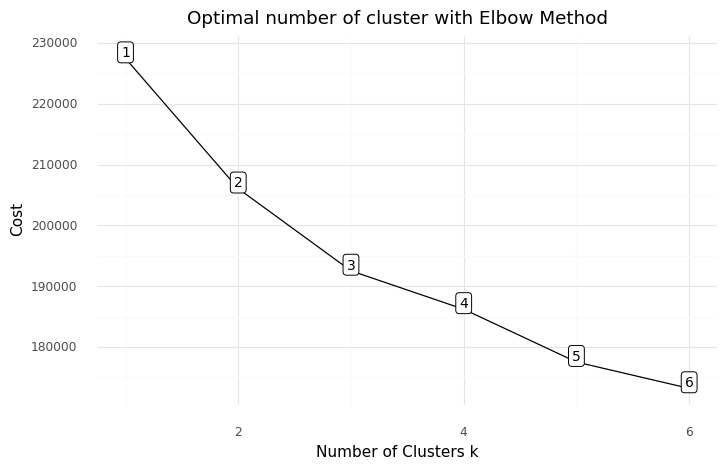

<ggplot: (121828968180)>

In [16]:
# Elbow 메소드 시각화
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1, 7), 'Cost':cost})
# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

- 위의 결과 2번 혹은 3번이 제일 좋아 보임

In [19]:
df_cost

,Cluster,Cost
0,1,227445.005839
1,2,206044.170110
2,3,192533.346000
3,4,186216.307273
4,5,177536.577802
5,6,173205.125643


- 우선 가장 값이 많이 떨어진 값인 2를 군집개수로 선택

# 군집개수 선택 후 모델 적합하기

In [ ]:
# Fit the cluster
# n_clusters = 2으로 한다
kprototype = KPrototypes(n_clusters = 2, init = 'Huang',
                                 random_state = 0, verbose = True)
kprototype.fit_predict(dfmatrix, categorical = catcol)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 45627, ncost: 211080.16993394858
Run: 1, iteration: 2/100, moves: 871, ncost: 211076.58162488264
Run: 1, iteration: 3/100, moves: 0, ncost: 211076.58162488264
Init: initializing centroids
Init: initializing clusters


# 기존 데이터 프레임에 분류된 군집 추가하기

In [ ]:
#new column for cluster labels associated with each subject
df2['cluster'] = kprototype.labels_ # 모든 컬럼 들어있는 데이터프레임에 군집 추가
ndf2['cluster'] = kprototype.labels_ # 군집화에 사용된 컬럼 들어있는 데이터프레임에 군집 추가

In [ ]:
df2.head()

In [ ]:
ndf2.head()